In [30]:
import logging
import churn_library
from churn_library import *
import constants  
from constants import *
import churn_script_logging_and_tests
from churn_script_logging_and_tests import *

# data loading

In [2]:
## import data
df = import_data(PATH_DATA)

df.head()


,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
0,0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0
2,2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0
3,3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0
4,4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0


# eda and viz

In [ ]:
## execute function
cat_columns = perform_eda(df = df)

# modeling


In [4]:
df = encoder_helper(df = df, category_lst = cat_columns)

In [5]:
X_train, X_test, y_train, y_test = perform_feature_engineering(df)

In [6]:
rfc_best, lrc = train_models(X_train, X_test,  y_train, y_test, estimate_new = False)

In [20]:
def feature_importance_plot(model, X_data, output_pth, modeldict):
    '''
    creates and stores the feature importances in pth
    input:
            model: model object containing feature_importances_
            X_data: pandas dataframe of X values
            output_pth: path to store the figure

    output:
             None
    '''
    
    ## first, check whether rf or lrc
    for key, value in modeldict.items():
        
        ## 1. Set up conditional logic to deal with RF fi
        ## versus LR coef
        if key == "Random Forest":
            imp = value[4].feature_importances_
            xlabel = "Feature importances for: " + key
        else:
            imp = value[4].coef_
            xlabel = "Coef for: " + key
            
        ## 2. create dataframe w/ info for plot
        df_forplot = pd.DataFrame({'imp_coef': imp,
                    'name': X_data.columns}).sort_values(by = 'imp_coef',
                     ascending = False)
        
        ## 3. Plot
        fi = sns.barplot(x="imp_coef", y="name", data= df_forplot)
        fi.set(ylabel="Feature", xlabel= xlabel)
        fi.savefig(output_pth + key + "_fiorcoef.png")
        
        ## 4. return nothing
        return Null 

        

<AxesSubplot:xlabel='Importances from  model', ylabel='Feature'>

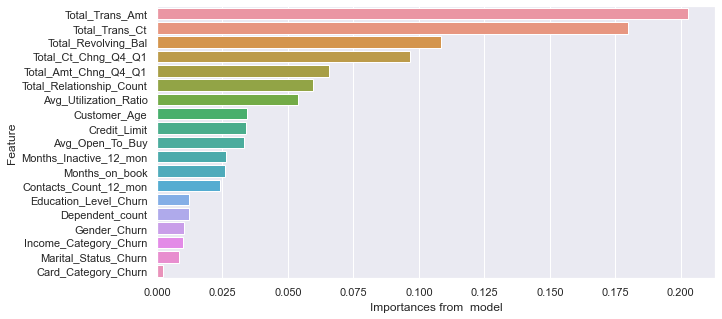

In [19]:
# Calculate feature importances
importances = pd.DataFrame({'imp_coef':
                            rfc_best.feature_importances_,
                            'name': X_train.columns}).sort_values(by = 'imp_coef',
                                                                 ascending = False)

# create sns barplot
fi = sns.barplot(x="imp_coef", y="name", data=importances)
fi.set(ylabel="Feature",
       xlabel="Importances from " + " model")
fi



In [36]:
## create roc curve plot 
y_pred_proba = lrc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig(PATH_RESULTS_FIGS + "test_roc.png")
plt.close()

AttributeError: 'RocCurveDisplay' object has no attribute 'savefig'

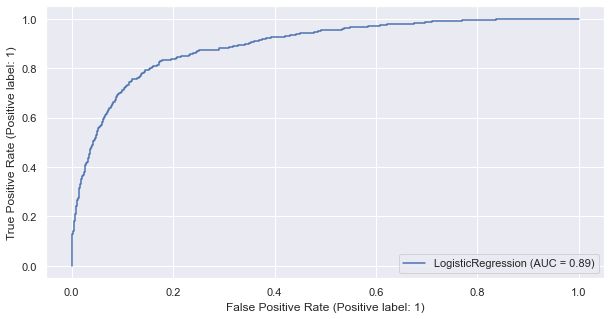

In [24]:
lrc_roc = plot_roc_curve(lrc, X_test, y_test)
lrc_roc.savefig(PATH_RESULTS_FIGS + "test.png")

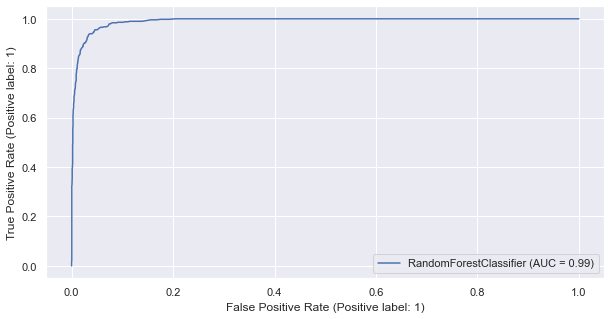

In [23]:
rfc_roc = plot_roc_curve(rfc_best, X_test, y_test)
rfc_roc

In [ ]:
# plots
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(cv_rfc.best_estimator_, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

In [ ]:
explainer = shap.TreeExplainer(cv_rfc.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
# Calculate feature importances
importances = cv_rfc.best_estimator_.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20,5))

# Create plot title
plt.title("Feature Importance")
plt.ylabel('Importance')

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90);